In [1]:
from skimage import exposure, filters
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage.morphology import square
from scipy.stats import mode

In [2]:
pixel_size = 16  #mu m
magnification = 126.7 
wavelength = 461 #nm

pixel_size_nm= (pixel_size*1000) / magnification
fwhm_nm = 470 

sigma_theorical = fwhm_nm / (2 * np.sqrt(2 * np.log(2)))
sigma_object_pixels = sigma_theorical / pixel_size_nm 


In [3]:
path_img = r"data\grid_definition"
images = os.listdir(path_img)

In [4]:
total_img = []
for i in images:
    img_n = cv.imread(path_img +"/"+ i, cv.IMREAD_GRAYSCALE)
    total_img.append(img_n)

In [5]:
def detect_points_function(img):
    list_is = []

    p2, p98 = np.percentile(img, (5, 95))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    img_filtered = filters.gaussian(img_rescale, sigma=2)

    selem_size = 3  # This value may need to be adjusted based on the actual image characteristics
    selem = square(selem_size)

    background = np.median(img_filtered)
    img_subtracted = img_filtered - background
    img_subtracted[img_subtracted < 0] = 0

    thresh = threshold_otsu(img_subtracted)
    binary_mask = img_subtracted > thresh

    img_subtracted_mask = img_subtracted * binary_mask

    # plt.figure(figsize=(8, 8))
    # plt.imshow(img, cmap=colormaps['BuPu'].reversed())
    # plt.autoscale(False)
    # #plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.', color='red')
    # plt.title('Data Treatment')
    # plt.show()

    coordinates = peak_local_max(img_subtracted_mask, min_distance=25)
    coordinates = np.array(coordinates)
    list_is.extend(coordinates)

    return list_is

In [6]:
data_img = {}
count = 0

for img in total_img:
    detected_points_array = np.array(detect_points_function(img))
    punts_detectats_corrected = np.copy(detected_points_array)
    punts_detectats_corrected[:, 0] = img.shape[0] - punts_detectats_corrected[:, 0]
    punts_detectats_corrected = punts_detectats_corrected[:, [1, 0]]
    detected_points_nm = punts_detectats_corrected*pixel_size_nm
    data_img[count] = detected_points_nm
    count = count + 1 

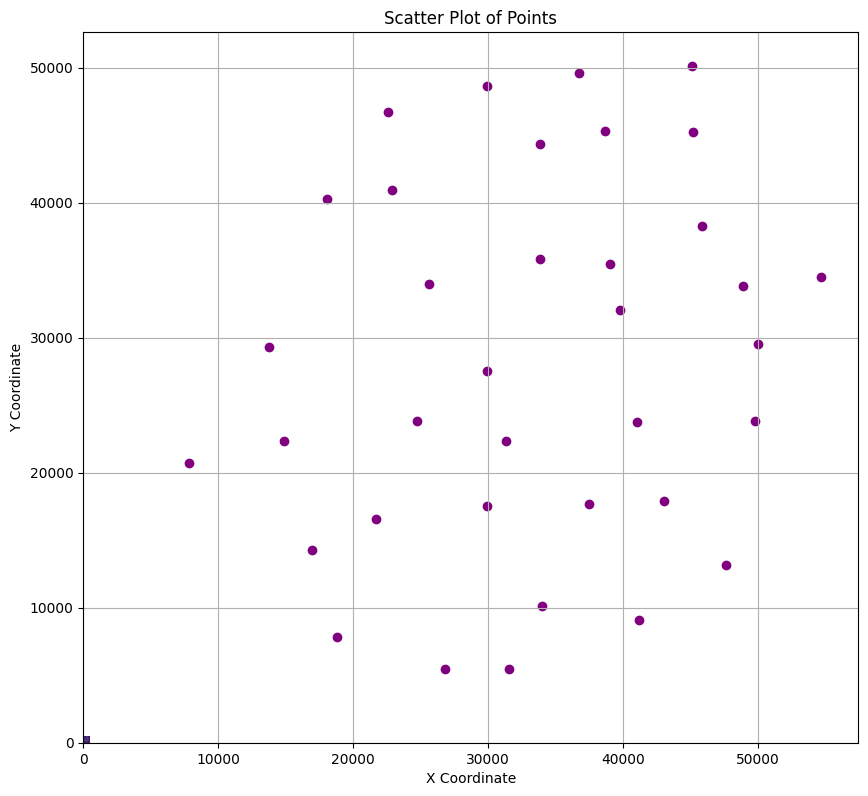

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(total_img[1])
plt.scatter(data_img[1][:, 0], data_img[1][:, 1], color='purple')
plt.gca().invert_yaxis()  # Invert the y-axis to match image coordinate system
plt.title('Scatter Plot of Points')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [8]:
length = max([img.shape[1] for img in total_img])*pixel_size_nm
heigh = max([img.shape[0] for img in total_img])*pixel_size_nm
image_shape = (length, heigh)

In [11]:
def draw_and_merge_lines(points, image_shape, threshold_range=200):
    """
    Draw and merge lines that are within a certain range, considering them as a single line by taking the average.
    
    :param points: Array of point coordinates.
    :param image_shape: Tuple indicating the size of the plot/image (height, width).
    :param threshold_range: Range within which lines are considered the same.
    """
    # Initialize lists to store the coordinates of unique lines
    unique_v_lines_x = []
    unique_h_lines_y = []

    # Sort points based on their x and y coordinates
    sorted_by_x = sorted(points, key=lambda p: p[0])
    sorted_by_y = sorted(points, key=lambda p: p[1])

    # Helper function to merge lines within a range and calculate the average
    def merge_lines(sorted_points, unique_lines):
        group = [sorted_points[0]]
        for coord in sorted_points[1:]:
            if abs(coord - group[-1]) <= threshold_range:
                group.append(coord)
            else:
                unique_lines.append(sum(group) / len(group))
                group = [coord]
        if group:
            unique_lines.append(sum(group) / len(group))

    # Merge lines
    merge_lines([p[0] for p in sorted_by_x], unique_v_lines_x)
    merge_lines([p[1] for p in sorted_by_y], unique_h_lines_y)

    # Plotting
    # fig, ax = plt.subplots(figsize=(10, 10))
    # ax.set_xlim(0, image_shape[1])
    # ax.set_ylim(image_shape[0], 0)

    # # Draw merged vertical lines
    # for x in unique_v_lines_x:
    #     ax.axvline(x=x, color='lightgray')

    # # Draw merged horizontal lines
    # for y in unique_h_lines_y:
    #     ax.axhline(y=y, color='lightgray')
    
    # # Plot points
    # for x, y in points:
    #     ax.plot(x, y, 'ro')

    # plt.show()

    return unique_v_lines_x, unique_h_lines_y


In [12]:
def agrupar_y_verificar_lineas(puntos, umbral_proximidad=100, min_puntos_linea=2):
    """
    Group and verify points to identify vertical and horizontal lines.

    :param puntos: List of tuples (x, y) representing point coordinates.
    :param umbral_proximidad: Threshold to consider points in the same potential line.
    :param min_puntos_linea: Minimum number of points to validate a line.
    :return: Sets of x coordinates of validated vertical lines and y coordinates of validated horizontal lines.
    """
    # Initialize lists for validated lines
    lineas_verticales_validadas = set()
    lineas_horizontales_validadas = set()

    # Helper function to group and verify lines in one dimension
    def procesar_lineas(coord_lineas, umbral, min_puntos):
        lineas_validadas = set()
        lineas_agrupadas = []
        points_apply = []

        # Sort and group
        for coord in sorted(coord_lineas):
            if not lineas_agrupadas or coord - lineas_agrupadas[-1][-1] > umbral:
                lineas_agrupadas.append([coord])
            else:
                lineas_agrupadas[-1].append(coord)

        # Verify if the groups constitute a line
        for grupo in lineas_agrupadas:
            if len(grupo) >= min_puntos:
                # Take the average coordinate of the group as the representative of the line
                lineas_validadas.add(round(sum(grupo) / len(grupo), 2))
                points_apply.extend(grupo)
        return lineas_validadas, points_apply

    # Extract x and y coordinates
    coord_x = [p[0] for p in puntos]
    coord_y = [p[1] for p in puntos]

    # Process vertical and horizontal lines
    lineas_verticales_validadas, points_apply_v = procesar_lineas(coord_x, umbral_proximidad, min_puntos_linea)
    lineas_horizontales_validadas, points_apply_h = procesar_lineas(coord_y, umbral_proximidad, min_puntos_linea)

    v = []
    h = []
    for x, y in puntos:
        if x not in points_apply_v:
            v.append(x)
        if y not in points_apply_h:
            h.append(y)
    
    lineas_verticales_validadas = list(lineas_verticales_validadas)
    lineas_horizontales_validadas = list(lineas_horizontales_validadas)

    lineas_verticales_validadas.extend(v)
    lineas_horizontales_validadas.extend(h)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, image_shape[1])
    ax.set_ylim(image_shape[0], 0)

    # Draw merged vertical lines
    for x in v:
        ax.axvline(x=x, color='lightgray')

    # Draw merged horizontal lines
    for y in h:
        ax.axhline(y=y, color='lightgray')
    
    # Plot points
    for x, y in puntos:
        ax.plot(x, y, 'ro', color='purple')

    # Draw validated vertical lines
    for x in lineas_verticales_validadas:
        ax.axvline(x=x, color='slategrey', alpha=0.6)
        
    # Draw validated horizontal lines
    for y in lineas_horizontales_validadas:
        ax.axhline(y=y, color='darkslategray', alpha=0.6)
    
    plt.show()

    return lineas_verticales_validadas, lineas_horizontales_validadas


In [ ]:
vertical = []
horizontal = []
dist_v = []
dist_h = []

for img, points in data_img.items():
    v_lines_u, h_lines_u = agrupar_y_verificar_lineas(points)
    vertical.append(list(v_lines_u))
    horizontal.append(list(h_lines_u))
    v_lines, h_lines = draw_and_merge_lines(points, image_shape)
    
    list(v_lines_u).extend(list(v_lines))
    list(h_lines_u).extend(list(h_lines))
    vertical.append(list(v_lines_u))
    horizontal.append(list(h_lines_u))

In [14]:
def calcular_y_filtrar_distancias(lineas):
    """
    Calculate distances between consecutive lines and filter according to a specific range.

    :param lineas: List of line coordinates (x for vertical or y for horizontal).
    :return: List of filtered distances between consecutive lines.
    """
    # Ensure the lines are sorted
    lineas_ordenadas = sorted(lineas)
    
    # Calculate distances between adjacent lines
    distancias = [lineas_ordenadas[i + 1] - lineas_ordenadas[i] for i in range(len(lineas_ordenadas) - 1)]
    
    # Filter distances that do not meet the criteria
    distancias_filtradas = [d for d in distancias if 350 < d < 1000]
    
    return distancias_filtradas


def encontrar_distancia_constante(distancias):
    """
    Find the most common distance between lines, which could indicate ax and ay.

    :param distancias: List of distances between adjacent lines.
    :return: The most common distance.
    """
    if len(distancias) == 0:
        return None
    
    # Find the most common distance
    distancia_mas_comun = mode(distancias).mode[0]
    
    return distancia_mas_comun


In [ ]:
distancias_verticales = []
distancias_horizontales = []
for i in range(len(vertical)):
    a = calcular_y_filtrar_distancias(vertical[i])
    distancias_verticales.append(encontrar_distancia_constante(a))

for i in range(len(horizontal)):
    b = calcular_y_filtrar_distancias(horizontal[i])
    distancias_horizontales.append(encontrar_distancia_constante(b))


In [16]:
np.mean(distancias_verticales)


521.9678422783487

In [17]:
np.mean(distancias_horizontales)

568.2715074980267

In [18]:
# Inputs
pixel_size = 16  # micrometers
magnification = 126.7
ax_nm = 521.97  # nanometers
ay_nm = 568.27  # nanometers

# Conversion factors
pixel_size_nm = (pixel_size * 1000) / magnification  # nanometers per pixel
conversion_factor = 1 / pixel_size_nm  # pixels per nanometer

# Conversion to pixels
ax_px = ax_nm * conversion_factor
ay_px = ay_nm * conversion_factor

print(f"Lattice grid in pixels: ax = {ax_px:.2f}, ay = {ay_px:.2f}")

Lattice grid in pixels: ax = 4.13, ay = 4.50


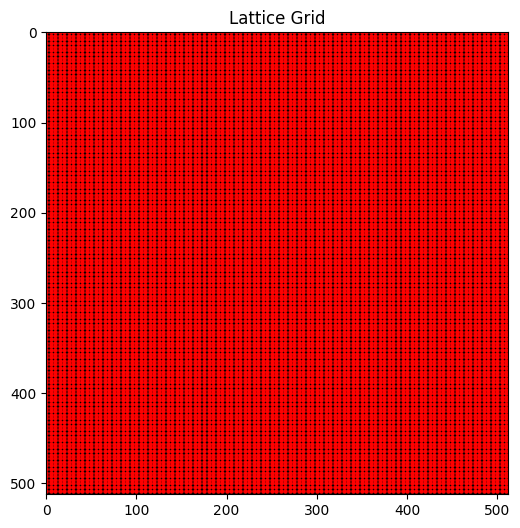

Lattice points (first 10):
[[ 0  0]
 [ 0  4]
 [ 0  8]
 [ 0 12]
 [ 0 16]
 [ 0 20]
 [ 0 24]
 [ 0 28]
 [ 0 32]
 [ 0 36]]
Total number of lattice points: 13184


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size in pixels
img_size = 512

# Step sizes for the lattice grid
ax = 5
ay = 4
# Generate the grid of points
x_coords = np.arange(0, img_size, ax)
y_coords = np.arange(0, img_size, ay)

# Create the lattice points by combining x and y coordinates
lattice_points = np.array([(x, y) for x in x_coords for y in y_coords])

# Optional: Visualize the grid points
plt.figure(figsize=(6, 6))
plt.imshow(np.zeros((img_size, img_size)), cmap='gray')
plt.scatter(lattice_points[:, 0], lattice_points[:, 1], color='red', s=5)
plt.xlim(0, img_size)
plt.ylim(0, img_size)
plt.gca().invert_yaxis()
plt.title("Lattice Grid")
plt.show()

# Display lattice points
print("Lattice points (first 10):")
print(lattice_points[:10])
print("Total number of lattice points:", len(lattice_points))


C:\Users\cristina soler\AppData\Local\Temp\ipykernel_12328\3378510174.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rotated_points[i::num_points_x, 0], rotated_points[i::num_points_x, 1], 'r-', color ='silver', linewidth=0.5, zorder=1)
C:\Users\cristina soler\AppData\Local\Temp\ipykernel_12328\3378510174.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rotated_points[index_range, 0], rotated_points[index_range, 1], 'r-', color ='silver',linewidth=0.5, zorder=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


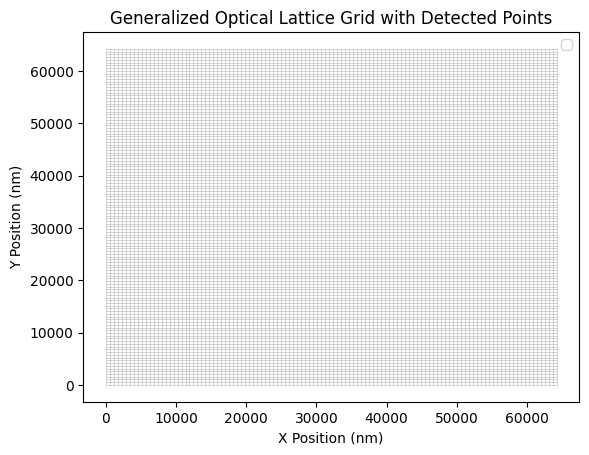

In [17]:
num_points_x = int(np.ceil(image_shape[0] / a_x))
num_points_y = int(np.ceil(image_shape[1] / a_y))

grid_x, grid_y = np.meshgrid(np.arange(num_points_x) * a_x, np.arange(num_points_y) * a_y)

# Plasmem en 2d per poder fer la rotació
points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Center of rotation
center_x, center_y = image_shape[0] / 2, image_shape[1] / 2

# Definim l'angle de rotació des de la vertical i el convertim de angle a radiants per la rotació
theta = np.radians(90 - 90) 

# Rotation matrix
c, s = np.cos(theta), np.sin(theta)
rotation_matrix = np.array([[c, -s], [s, c]])

# Rotate points
rotated_points = np.dot(points - np.array([center_x, center_y]), rotation_matrix) + np.array([center_x, center_y])

# Drawing the rotated grid lines
for i in range(num_points_x):
    plt.plot(rotated_points[i::num_points_x, 0], rotated_points[i::num_points_x, 1], 'r-', color ='silver', linewidth=0.5, zorder=1)
for i in range(num_points_y):
    index_range = slice(i * num_points_x, (i + 1) * num_points_x)
    plt.plot(rotated_points[index_range, 0], rotated_points[index_range, 1], 'r-', color ='silver',linewidth=0.5, zorder=1)

plt.xlabel('X Position (nm)')
plt.ylabel('Y Position (nm)')
plt.title('Generalized Optical Lattice Grid with Detected Points')
plt.legend()
plt.show()

In [43]:
def convert_nm_to_pixels(lattice_grid_nm, pixel_size_nm):
    """
    Convert lattice grid coordinates from nanometers to pixels.
    
    Parameters:
    - lattice_grid_nm: A list of (x, y) tuples with coordinates in nanometers.
    - pixel_size_nm: Size of one pixel in nanometers.
    
    Returns:
    - A list of (x, y) tuples with coordinates in pixels.
    """
    lattice_grid_pixels = [[int(x / pixel_size_nm), int(y / pixel_size_nm)] for x, y in lattice_grid_nm]
    return lattice_grid_pixels

lattice_grid_px = convert_nm_to_pixels(rotated_points, pixel_size_nm)

In [44]:
lattice_grid_px

[[0, 0],
 [4, 0],
 [8, 0],
 [13, 0],
 [18, 0],
 [22, 0],
 [26, 0],
 [31, 0],
 [35, 0],
 [40, 0],
 [45, 0],
 [49, 0],
 [53, 0],
 [58, 0],
 [63, 0],
 [67, 0],
 [71, 0],
 [76, 0],
 [80, 0],
 [85, 0],
 [90, 0],
 [94, 0],
 [98, 0],
 [103, 0],
 [108, 0],
 [112, 0],
 [116, 0],
 [121, 0],
 [125, 0],
 [130, 0],
 [135, 0],
 [139, 0],
 [143, 0],
 [148, 0],
 [152, 0],
 [157, 0],
 [161, 0],
 [166, 0],
 [170, 0],
 [175, 0],
 [180, 0],
 [184, 0],
 [188, 0],
 [193, 0],
 [197, 0],
 [202, 0],
 [206, 0],
 [211, 0],
 [215, 0],
 [220, 0],
 [224, 0],
 [229, 0],
 [233, 0],
 [238, 0],
 [242, 0],
 [247, 0],
 [251, 0],
 [256, 0],
 [260, 0],
 [265, 0],
 [270, 0],
 [274, 0],
 [279, 0],
 [283, 0],
 [287, 0],
 [292, 0],
 [296, 0],
 [301, 0],
 [305, 0],
 [310, 0],
 [315, 0],
 [319, 0],
 [323, 0],
 [328, 0],
 [332, 0],
 [337, 0],
 [341, 0],
 [346, 0],
 [350, 0],
 [355, 0],
 [360, 0],
 [364, 0],
 [368, 0],
 [373, 0],
 [377, 0],
 [382, 0],
 [386, 0],
 [391, 0],
 [395, 0],
 [400, 0],
 [404, 0],
 [409, 0],
 [413, 0],
 [4

C:\Users\cristina soler\AppData\Local\Temp\ipykernel_12328\1103125818.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rotated_points[i::num_points_x, 0], rotated_points[i::num_points_x, 1], 'r-', color ='silver', linewidth=0.5, zorder=1)
C:\Users\cristina soler\AppData\Local\Temp\ipykernel_12328\1103125818.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rotated_points[index_range, 0], rotated_points[index_range, 1], 'r-', color ='silver',linewidth=0.5, zorder=1)


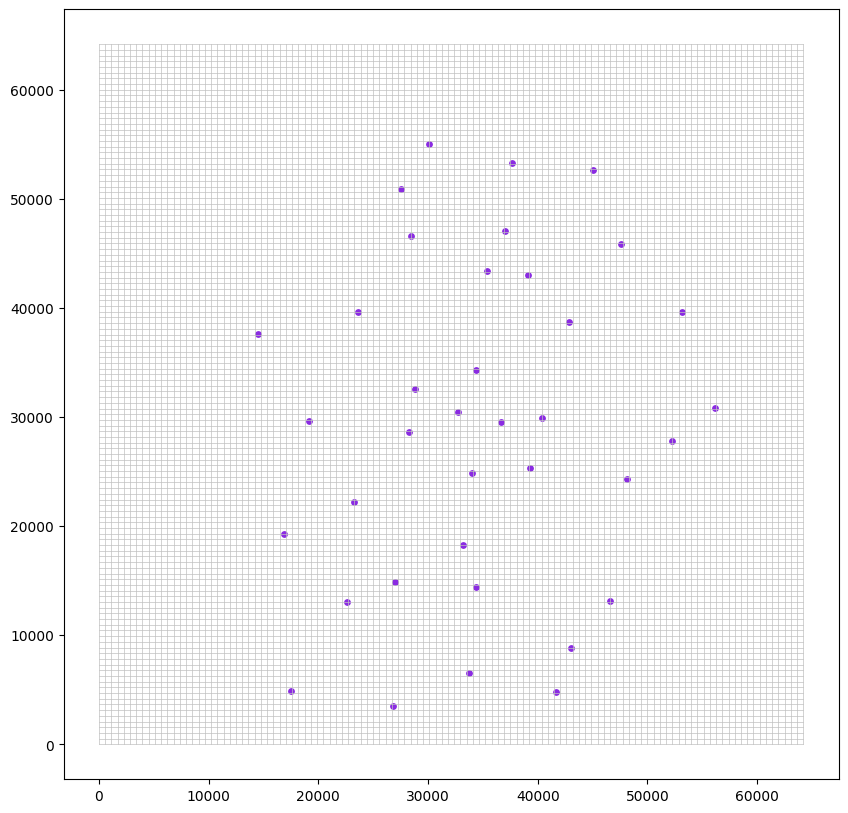

In [18]:
list_is = []
# Busquem els màxims locals de la imatge
list_is = detect_points_function(total_img[5])

single_detect_points = np.array(list_is)
single_detect_points[:, 0] = 512 - single_detect_points[:, 0]
single_detect_points = single_detect_points[:, [1, 0]]
single_points_nm = single_detect_points*pixel_size_nm

plt.figure(figsize=(10, 10))

plt.scatter(single_points_nm[:, 0], single_points_nm[:, 1], color='blueviolet', label='Detected Points', zorder=1, s=15)

for i in range(num_points_x):
    plt.plot(rotated_points[i::num_points_x, 0], rotated_points[i::num_points_x, 1], 'r-', color ='silver', linewidth=0.5, zorder=1)
for i in range(num_points_y):
    index_range = slice(i * num_points_x, (i + 1) * num_points_x)
    plt.plot(rotated_points[index_range, 0], rotated_points[index_range, 1], 'r-', color ='silver',linewidth=0.5, zorder=1)


In [37]:
def convert_nm_to_pixels(lattice_grid_nm, pixel_size_nm):
    """
    Convert lattice grid coordinates from nanometers to pixels.
    
    Parameters:
    - lattice_grid_nm: A list of (x, y) tuples with coordinates in nanometers.
    - pixel_size_nm: Size of one pixel in nanometers.
    
    Returns:
    - A list of (x, y) tuples with coordinates in pixels.
    """
    lattice_grid_pixels = [[int(x / pixel_size_nm), int(y / pixel_size_nm)] for x, y in lattice_grid_nm]
    return lattice_grid_pixels

lattice_grid_px = convert_nm_to_pixels(lattice_grid_px, pixel_size_nm)